<a href="https://colab.research.google.com/github/BytesizeWonders/Image-process/blob/main/Image_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install torch torchvision opencv-python

In [36]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import shutil
import os

In [37]:
from google.colab import files

uploaded = files.upload()  # This will open a dialog to upload an image
uploaded_image_name = list(uploaded.keys())[0]  # Get the name of the uploaded image

# Move the uploaded image to a specific directory
if not os.path.exists('data/input_images'):
    os.makedirs('data/input_images')
shutil.move(uploaded_image_name, f'data/input_images/{uploaded_image_name}')

image_path = f'data/input_images/{uploaded_image_name}'

Saving woman-with-motorbike.jpg to woman-with-motorbike (2).jpg


In [38]:
def load_image(image_path):
    image = cv2.imread(image_path)  # Load the image using OpenCV
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying
    transform = torchvision.transforms.ToTensor()  # Convert image to tensor
    image_tensor = transform(image_rgb)
    return image, image_tensor

In [39]:
def segment_image(image_tensor):
    # Load pre-trained Mask R-CNN from TorchHub
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()  # Set the model to evaluation mode

    # Perform inference
    with torch.no_grad():
        prediction = model([image_tensor])

    # Get masks, bounding boxes, and labels from the prediction
    masks = prediction[0]['masks']
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']

    return masks, boxes, labels

In [40]:
def visualize_segments(image, masks, boxes, labels):
    for i in range(masks.shape[0]):
        mask = masks[i, 0].mul(255).byte().cpu().numpy()  # Extract mask
        image_with_mask = image.copy()
        image_with_mask[mask == 255] = [0, 255, 0]  # Apply green color to mask

        # Draw bounding box
        box = boxes[i].cpu().numpy().astype(int)
        cv2.rectangle(image_with_mask, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

        # Convert BGR to RGB for Matplotlib
        image_with_mask = cv2.cvtColor(image_with_mask, cv2.COLOR_BGR2RGB)

        # Display the image with the segmentation
        plt.figure(figsize=(8, 8))
        plt.imshow(image_with_mask)
        plt.title(f'Object {i + 1}, Label: {labels[i].item()}')
        plt.axis('off')
        plt.show()

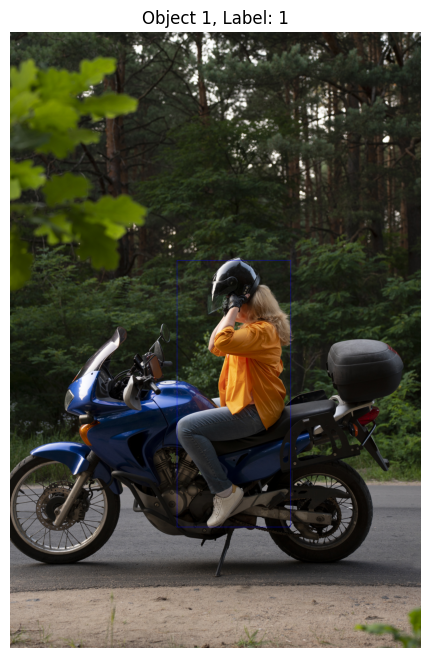

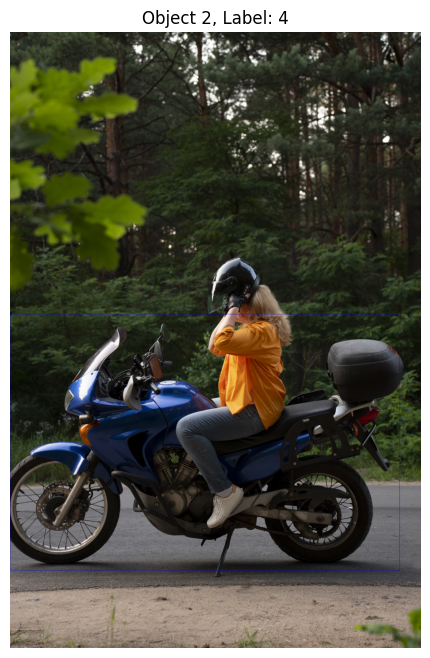

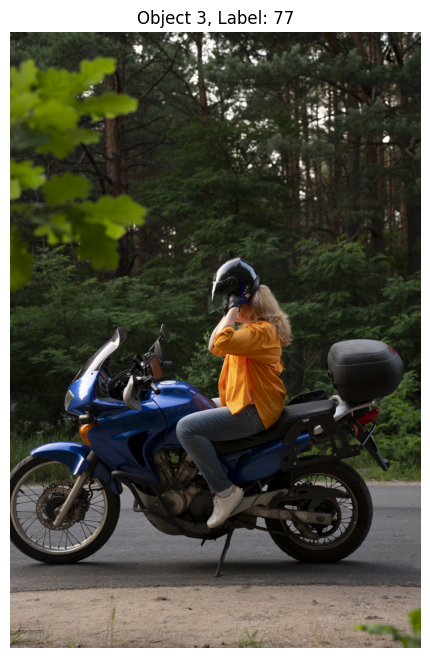

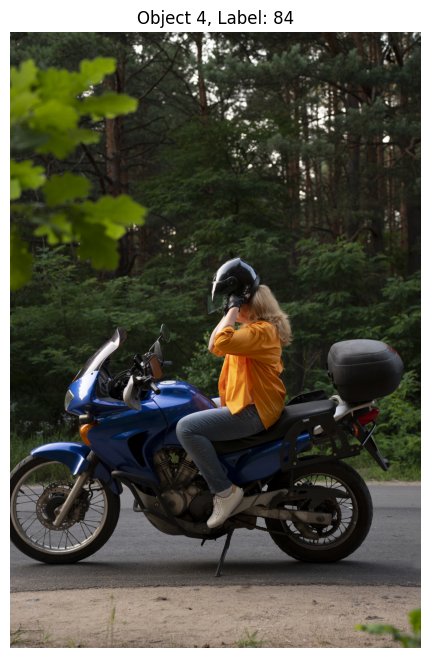

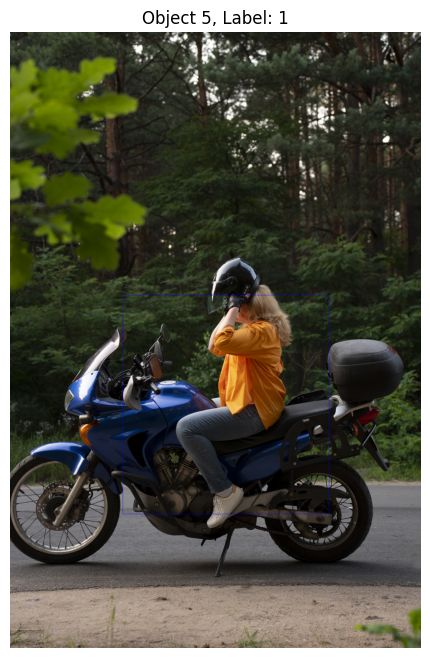

In [41]:
def main(image_path):
    # Load the image and convert to tensor
    image, image_tensor = load_image(image_path)

    # Perform image segmentation
    masks, boxes, labels = segment_image(image_tensor)

    # Visualize the segmented objects
    if masks.shape[0] > 0:
        visualize_segments(image, masks, boxes, labels)
    else:
        print("No objects detected.")

# Run the pipeline
main(image_path)

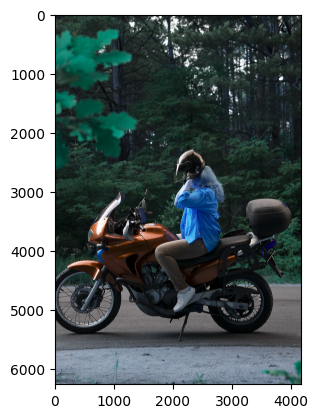

In [42]:
# Test Visualization with the Uploaded Image
image, _ = load_image(image_path)  # Load image
plt.imshow(image)
plt.show()

#Step 2: Object Extraction and Storage


In [43]:
from google.colab import files
import os
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.transforms import functional as F

In [44]:
# Upload the image
uploaded = files.upload()

Saving woman-with-motorbike.jpg to woman-with-motorbike (2).jpg


In [45]:
# Ensure the folder exists
if not os.path.exists('data/input_images/'):
    os.makedirs('data/input_images/')

In [46]:
# Save the uploaded image to the correct folder
for filename in uploaded.keys():
    image_path = os.path.join('data/input_images', filename)
    with open(image_path, 'wb') as f:
        f.write(uploaded[filename])

print(f"Image uploaded and saved at: {image_path}")

Image uploaded and saved at: data/input_images/woman-with-motorbike (2).jpg


In [47]:
# Load a pre-trained Mask R-CNN model
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [48]:
# Function to assign unique IDs to segmented objects
def generate_unique_id(image_id, obj_num):
    return f"{image_id}_obj_{obj_num}"

In [49]:
# Function to extract and save segmented objects
def extract_and_save_objects(image_path):
    image_id = os.path.splitext(os.path.basename(image_path))[0]  # Get image ID from filename

    # Read image
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    # Run the segmentation model
    with torch.no_grad():
        predictions = model(image_tensor)

    masks = predictions[0]['masks'].cpu().numpy()  # Extract masks
    boxes = predictions[0]['boxes'].cpu().numpy()  # Extract bounding boxes
    labels = predictions[0]['labels'].cpu().numpy()  # Extract labels

    # Loop through each detected object
    for i in range(len(masks)):
        mask = masks[i, 0]
        box = boxes[i].astype(int)

        # Extract object region from the original image using the mask
        segmented_obj = np.array(image)
        segmented_obj[mask == 0] = 0  # Set the background to black

        # Crop the object using bounding box
        cropped_obj = segmented_obj[box[1]:box[3], box[0]:box[2], :]

        # Assign a unique ID to the object and save it
        unique_id = generate_unique_id(image_id, i + 1)
        output_path = f"data/segmented_objects/{unique_id}.png"
        os.makedirs('data/segmented_objects/', exist_ok=True)  # Ensure folder exists
        cv2.imwrite(output_path, cv2.cvtColor(cropped_obj, cv2.COLOR_RGB2BGR))  # Save the image

        print(f"Object {i+1} saved with ID: {unique_id} at {output_path}")

    return len(masks)  # Return the number of segmented objects

# Now that the image is uploaded, run the object extraction
num_objects = extract_and_save_objects(image_path)
print(f"Extracted and saved {num_objects} objects.")

Object 1 saved with ID: woman-with-motorbike (2)_obj_1 at data/segmented_objects/woman-with-motorbike (2)_obj_1.png
Object 2 saved with ID: woman-with-motorbike (2)_obj_2 at data/segmented_objects/woman-with-motorbike (2)_obj_2.png
Object 3 saved with ID: woman-with-motorbike (2)_obj_3 at data/segmented_objects/woman-with-motorbike (2)_obj_3.png
Object 4 saved with ID: woman-with-motorbike (2)_obj_4 at data/segmented_objects/woman-with-motorbike (2)_obj_4.png
Object 5 saved with ID: woman-with-motorbike (2)_obj_5 at data/segmented_objects/woman-with-motorbike (2)_obj_5.png
Extracted and saved 5 objects.


# Step 3: Object Identification and Description Using Pre-trained Model (YOLO or Faster R-CNN)

In [50]:
!pip install torch torchvision opencv-python pillow

In [52]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import cv2
import sqlite3
import os

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Transform function to resize and normalize images for the model
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to identify and describe objects in each segmented image
def identify_objects(image_path, object_id, db_file):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Run inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Get the labels (categories) and boxes from the model predictions
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    boxes = predictions[0]['boxes'].cpu().numpy()

    # Class labels from COCO dataset (used for pre-trained Faster R-CNN)
    COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
        'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
        'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
        'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
        'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
        'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
        'toothbrush'
    ]

    # Filter predictions based on score threshold
    score_threshold = 0.5
    identified_objects = []
    for label, score, box in zip(labels, scores, boxes):
        if score > score_threshold:
            object_label = COCO_INSTANCE_CATEGORY_NAMES[label]
            identified_objects.append({
                "label": object_label,
                "score": score,
                "box": box
            })

    # Print identified objects
    print(f"Identified objects in {image_path}:")
    for obj in identified_objects:
        print(f"Label: {obj['label']}, Score: {obj['score']}")

    # Store metadata in SQLite database
    store_metadata_in_db(identified_objects, object_id, db_file)

    return identified_objects

# Function to store metadata in the SQLite database
def store_metadata_in_db(objects, object_id, db_file):
    # Create the directory for the database file if it doesn't exist
    os.makedirs(os.path.dirname(db_file), exist_ok=True)

    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS object_identification
                      (object_id TEXT, label TEXT, score REAL, bbox TEXT)''')

    for obj in objects:
        cursor.execute('''INSERT INTO object_identification (object_id, label, score, bbox)
                          VALUES (?, ?, ?, ?)''',
                          (object_id, obj['label'], obj['score'], str(obj['box'])))

    conn.commit()
    conn.close()

    print(f"Metadata for object {object_id} stored in {db_file}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
import sqlite3
import os

# Path to the database file
db_file = 'data/database/objects.db'

# Function to create the database table if it doesn't exist
def create_table(db_file):
    # Create the directory for the database file if it doesn't exist
    os.makedirs(os.path.dirname(db_file), exist_ok=True)

    # Connect to the database
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Create the table if it doesn't exist
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS object_identification (
        object_id TEXT PRIMARY KEY,
        master_image_id TEXT,
        description TEXT
    )
    ''')

    conn.commit()  # Save changes
    conn.close()

# Function to insert data into the table
def insert_data(db_file, object_id, master_image_id, description):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Insert object data
    cursor.execute('''
    INSERT INTO object_identification (object_id, master_image_id, description)
    VALUES (?, ?, ?)
    ''', (object_id, master_image_id, description))

    conn.commit()
    conn.close()

# Check contents of the database
def check_db_contents(db_file):
    # Create the directory for the database file if it doesn't exist
    os.makedirs(os.path.dirname(db_file), exist_ok=True)

    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Check if the table exists before querying
    cursor.execute("SELECT count(name) FROM sqlite_master WHERE type='table' AND name='object_identification'")
    if cursor.fetchone()[0] == 1:
        cursor.execute("SELECT * FROM object_identification")
        rows = cursor.fetchall()
        for row in rows:
            print(row)
    else:
        print("The table 'object_identification' does not exist in the database.")

    conn.close()

# Test the functions
create_table(db_file)

# Insert test data (you can insert multiple objects)
insert_data(db_file, "obj_1", "master_img_1", "Description of object 1")
insert_data(db_file, "obj_2", "master_img_1", "Description of object 2")

# Check the database contents
check_db_contents(db_file)

('obj_1', 'master_img_1', 'Description of object 1')
('obj_2', 'master_img_1', 'Description of object 2')


# Step 4: Text/Data Extraction Using EasyOCR

In [59]:
!pip install easyocr
# Installs the EasyOCR library.

import easyocr
import sqlite3
import os
from PIL import Image

# Initialize the EasyOCR reader (supports multiple languages)
reader = easyocr.Reader(['en'])  # Specify language here, 'en' for English

# Function to perform text extraction using EasyOCR
def extract_text(image_path, object_id, db_file):
    # Perform OCR on the image
    result = reader.readtext(image_path)

    # Store the extracted text
    extracted_text = " ".join([res[1] for res in result])  # Combine the text results

    print(f"Extracted text from {image_path}: {extracted_text}")

    # Save the extracted text in the database
    save_text_to_db(object_id, extracted_text, db_file)

    return extracted_text

# Function to save the extracted text to the SQLite database
def save_text_to_db(object_id, text, db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Create the table if it doesn't exist
    cursor.execute('''CREATE TABLE IF NOT EXISTS object_text_data
                      (object_id TEXT, extracted_text TEXT)''')

    # Insert the extracted text data into the database
    cursor.execute('''INSERT INTO object_text_data (object_id, extracted_text)
                      VALUES (?, ?)''', (object_id, text))

    conn.commit()
    conn.close()

# Directory containing segmented object images
image_dir = 'data/segmented_objects/'
db_file = 'data/output/extracted_text.db'

# Run text extraction on each segmented object image
for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    object_id = os.path.splitext(image_file)[0]  # Use the image filename as object ID
    extract_text(image_path, object_id, db_file)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 23.4 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteExtracted text from data/segmented_objects/woman-with-motorbike_obj_3.png: 
Extracted text from data/segmented_objects/woman-with-motorbike_obj_2.png: 
Extracted text from data/segmented_objects/woman-with-motorbike_obj_4.png: 
Extracted text from data/segmented_objects/woman-with-motorbike (1)_obj_3.png: 
Extracted text from data/segmented_objects/woman-with-motorbike_obj_5.png: 
Extracted text from data/segmented_objects/woman-with-motorbike (1)_obj_2.png: 
Extracted text from data/segmented_objects/woman-with-motorbike (1)_obj_4.png: 
Extracted text from data/segmented_objects/woman-with-motorbike_obj_1.png: 
Extracted text from data/segmented_objects/woman-with-motorbike (2)_obj_4.png: 
Extracted text from data/segmented_objects/woman-with-motorbike (1)_obj_1.png: 
Extracted text from data/segmented_objects/woman-with-motorbike (1)_obj_5.png: 
Extracted text from data/segmented_objects/woman-with-motorbik

In [60]:
# Function to view the extracted text data in the database
def view_extracted_text(db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Query the extracted text
    cursor.execute("SELECT * FROM object_text_data")
    rows = cursor.fetchall()

    for row in rows:
        print(f"Object ID: {row[0]}, Extracted Text: {row[1]}")

    conn.close()

# Test: View extracted text data
view_extracted_text(db_file)

Object ID: woman-with-motorbike_obj_3, Extracted Text: 
Object ID: woman-with-motorbike_obj_2, Extracted Text: 
Object ID: woman-with-motorbike_obj_4, Extracted Text: 
Object ID: woman-with-motorbike (1)_obj_3, Extracted Text: 
Object ID: woman-with-motorbike_obj_5, Extracted Text: 
Object ID: woman-with-motorbike (1)_obj_2, Extracted Text: 
Object ID: woman-with-motorbike (1)_obj_4, Extracted Text: 
Object ID: woman-with-motorbike_obj_1, Extracted Text: 
Object ID: woman-with-motorbike (2)_obj_4, Extracted Text: 
Object ID: woman-with-motorbike (1)_obj_1, Extracted Text: 
Object ID: woman-with-motorbike (1)_obj_5, Extracted Text: 
Object ID: woman-with-motorbike (2)_obj_1, Extracted Text: 
Object ID: woman-with-motorbike (2)_obj_5, Extracted Text: 
Object ID: woman-with-motorbike (2)_obj_3, Extracted Text: 
Object ID: woman-with-motorbike (2)_obj_2, Extracted Text: 


# Step 5: Summarize Object Attributes

In [61]:
!pip install transformers torch sqlite3 pandas

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [62]:
from transformers import pipeline
import sqlite3
import os

# Load the summarization model (BART or T5)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Function to summarize object attributes
def summarize_attributes(object_id, object_data, db_file):
    # Prepare the input text for summarization
    summary_input = f"Object ID: {object_id}\n"
    summary_input += f"Type: {object_data['type']}\n"
    summary_input += f"Bounding Box: {object_data['bbox']}\n"
    summary_input += f"Extracted Text: {object_data['extracted_text']}\n"

    # Generate a summary using the NLP model
    summary = summarizer(summary_input, max_length=50, min_length=10, do_sample=False)[0]['summary_text']

    # Store the summary in the database
    save_summary_to_db(object_id, summary, db_file)

    return summary

# Function to save the summary to SQLite database
def save_summary_to_db(object_id, summary, db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Create the table if it doesn't exist
    cursor.execute('''CREATE TABLE IF NOT EXISTS object_summary_data
                      (object_id TEXT, summary TEXT)''')

    # Insert the summary data
    cursor.execute('''INSERT INTO object_summary_data (object_id, summary)
                      VALUES (?, ?)''', (object_id, summary))

    conn.commit()
    conn.close()

# Sample object data dictionary (you'll replace this with actual data from the pipeline)
object_data_example = {
    "type": "Traffic Sign",
    "bbox": "x1: 100, y1: 200, x2: 400, y2: 600",
    "extracted_text": "STOP"
}

# Directory and database file for storing summaries
db_file = 'data/output/object_summaries.db'

# Summarize attributes for each object
for object_file in os.listdir('data/segmented_objects/'):
    object_id = os.path.splitext(object_file)[0]
    # You can replace this with actual data for each object collected from previous steps
    object_data = object_data_example
    summary = summarize_attributes(object_id, object_data, db_file)
    print(f"Summary for {object_id}: {summary}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Summary for woman-with-motorbike_obj_3: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600.Extracted Text: STOP STOP STOP. Object ID: woman-with-motorbike_obj_3.
Summary for woman-with-motorbike_obj_2: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600.Extracted Text: STOP STOP STOP. Object ID: woman-with-motorbike_obj_2.
Summary for woman-with-motorbike_obj_4: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600.Extracted Text: STOP STOP STOP. Object ID: woman-with-motorbike_obj_4.
Summary for woman-with-motorbike (1)_obj_3: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600Extracted Text: STOP STOP STOP. Object ID: woman-with-motorbike (1:_obj_
Summary for woman-with-motorbike_obj_5: Object ID: woman-with-motorbike_obj_5Type: Traffic SignBounding Box: x1: 100, y1: 200, x2: 400, y2: 600.Extracted Text: STOP
Summary for woman-with-motorbike (1)_obj_2: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600Extracted Text: STOP STOP STOP. Object ID: woman-with-motorbike (1:_obj_
Summary for woman-with-mo

In [63]:
# Function to view summarized object data in the database
def view_summarized_data(db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Query the summarized data
    cursor.execute("SELECT * FROM object_summary_data")
    rows = cursor.fetchall()

    for row in rows:
        print(f"Object ID: {row[0]}, Summary: {row[1]}")

    conn.close()

# View all summaries in the database
view_summarized_data(db_file)

Object ID: woman-with-motorbike_obj_3, Summary: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600.Extracted Text: STOP STOP STOP. Object ID: woman-with-motorbike_obj_3.
Object ID: woman-with-motorbike_obj_2, Summary: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600.Extracted Text: STOP STOP STOP. Object ID: woman-with-motorbike_obj_2.
Object ID: woman-with-motorbike_obj_4, Summary: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600.Extracted Text: STOP STOP STOP. Object ID: woman-with-motorbike_obj_4.
Object ID: woman-with-motorbike (1)_obj_3, Summary: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600Extracted Text: STOP STOP STOP. Object ID: woman-with-motorbike (1:_obj_
Object ID: woman-with-motorbike_obj_5, Summary: Object ID: woman-with-motorbike_obj_5Type: Traffic SignBounding Box: x1: 100, y1: 200, x2: 400, y2: 600.Extracted Text: STOP
Object ID: woman-with-motorbike (1)_obj_2, Summary: Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600Extracted Text: STOP STOP STOP. Object ID: woman-w

# Step 6: Data Mapping

In [64]:
import json
import os
import sqlite3

# Function to map object data and save as JSON
def map_data_to_json(master_image_id, object_data_list, output_file):
    data_mapping = {
        "master_image_id": master_image_id,
        "objects": []
    }

    # Iterate through the list of object data
    for obj_data in object_data_list:
        object_entry = {
            "object_id": obj_data['object_id'],
            "description": obj_data['description'],
            "bounding_box": obj_data['bbox'],
            "extracted_text": obj_data['extracted_text'],
            "summary": obj_data['summary']
        }
        data_mapping["objects"].append(object_entry)

    # Save the data mapping as JSON
    with open(output_file, 'w') as outfile:
        json.dump(data_mapping, outfile, indent=4)

# Sample object data (you'll replace this with actual data from your pipeline)
object_data_example = [
    {
        "object_id": "object_1",
        "description": "Traffic Sign",
        "bbox": "x1: 100, y1: 200, x2: 400, y2: 600",
        "extracted_text": "STOP",
        "summary": "This is a traffic sign with the text STOP."
    },
    {
        "object_id": "object_2",
        "description": "Billboard",
        "bbox": "x1: 50, y1: 150, x2: 300, y2: 450",
        "extracted_text": "Safety First",
        "summary": "This is a billboard with a safety warning."
    }
]

# Mapping the data to a master image (replace master_image_id with actual data)
master_image_id = "woman-with-motorbike"
output_json_file = "data/output/mapped_data.json"

# Map the data and save it as a JSON file
map_data_to_json(master_image_id, object_data_example, output_json_file)
print(f"Data mapping saved to {output_json_file}")

Data mapping saved to data/output/mapped_data.json


In [65]:
{
    "master_image_id": "woman-with-motorbike",
    "objects": [
        {
            "object_id": "object_1",
            "description": "Traffic Sign",
            "bounding_box": "x1: 100, y1: 200, x2: 400, y2: 600",
            "extracted_text": "STOP",
            "summary": "This is a traffic sign with the text STOP."
        },
        {
            "object_id": "object_2",
            "description": "Billboard",
            "bounding_box": "x1: 50, y1: 150, x2: 300, y2: 450",
            "extracted_text": "Safety First",
            "summary": "This is a billboard with a safety warning."
        }
    ]
}

{'master_image_id': 'woman-with-motorbike',
 'objects': [{'object_id': 'object_1',
   'description': 'Traffic Sign',
   'bounding_box': 'x1: 100, y1: 200, x2: 400, y2: 600',
   'extracted_text': 'STOP',
   'summary': 'This is a traffic sign with the text STOP.'},
  {'object_id': 'object_2',
   'description': 'Billboard',
   'bounding_box': 'x1: 50, y1: 150, x2: 300, y2: 450',
   'extracted_text': 'Safety First',
   'summary': 'This is a billboard with a safety warning.'}]}

In [66]:
import sqlite3

# Function to create tables in SQLite database
def create_tables(db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Create table for master images
    cursor.execute('''CREATE TABLE IF NOT EXISTS master_image_data
                      (master_image_id TEXT PRIMARY KEY, image_path TEXT)''')

    # Create table for object data
    cursor.execute('''CREATE TABLE IF NOT EXISTS object_data
                      (object_id TEXT PRIMARY KEY, master_image_id TEXT,
                       description TEXT, bbox TEXT, extracted_text TEXT, summary TEXT,
                       FOREIGN KEY(master_image_id) REFERENCES master_image_data(master_image_id))''')

    conn.commit()
    conn.close()

# Function to insert master image data
def insert_master_image_data(master_image_id, image_path, db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    cursor.execute('''INSERT INTO master_image_data (master_image_id, image_path)
                      VALUES (?, ?)''', (master_image_id, image_path))

    conn.commit()
    conn.close()

# Function to insert object data
def insert_object_data(object_id, master_image_id, description, bbox, extracted_text, summary, db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    cursor.execute('''INSERT INTO object_data (object_id, master_image_id, description, bbox, extracted_text, summary)
                      VALUES (?, ?, ?, ?, ?, ?)''', (object_id, master_image_id, description, bbox, extracted_text, summary))

    conn.commit()
    conn.close()

# Sample object data (replace with actual object data from pipeline)
object_data_example = [
    {
        "object_id": "object_1",
        "description": "Traffic Sign",
        "bbox": "x1: 100, y1: 200, x2: 400, y2: 600",
        "extracted_text": "STOP",
        "summary": "This is a traffic sign with the text STOP."
    },
    {
        "object_id": "object_2",
        "description": "Billboard",
        "bbox": "x1: 50, y1: 150, x2: 300, y2: 450",
        "extracted_text": "Safety First",
        "summary": "This is a billboard with a safety warning."
    }
]

# Database file
db_file = 'data/output/mapped_data.db'

# Create tables
create_tables(db_file)

# Insert master image data
master_image_id = "woman-with-motorbike"
image_path = "data/input_images/woman-with-motorbike.jpg"
insert_master_image_data(master_image_id, image_path, db_file)

# Insert object data
for obj_data in object_data_example:
    insert_object_data(
        obj_data['object_id'],
        master_image_id,
        obj_data['description'],
        obj_data['bbox'],
        obj_data['extracted_text'],
        obj_data['summary'],
        db_file
    )

print(f"Data mapping stored in {db_file}")

Data mapping stored in data/output/mapped_data.db


In [67]:
def view_mapped_data(db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Query the data
    cursor.execute('''SELECT o.object_id, o.description, o.bbox, o.extracted_text, o.summary, m.master_image_id
                      FROM object_data o
                      JOIN master_image_data m ON o.master_image_id = m.master_image_id''')

    rows = cursor.fetchall()

    for row in rows:
        print(f"Object ID: {row[0]}, Description: {row[1]}, Bounding Box: {row[2]}, Extracted Text: {row[3]}, Summary: {row[4]}, Master Image: {row[5]}")

    conn.close()

# View all mapped data
view_mapped_data(db_file)

Object ID: object_1, Description: Traffic Sign, Bounding Box: x1: 100, y1: 200, x2: 400, y2: 600, Extracted Text: STOP, Summary: This is a traffic sign with the text STOP., Master Image: woman-with-motorbike
Object ID: object_2, Description: Billboard, Bounding Box: x1: 50, y1: 150, x2: 300, y2: 450, Extracted Text: Safety First, Summary: This is a billboard with a safety warning., Master Image: woman-with-motorbike


# Step 7: Output Generation

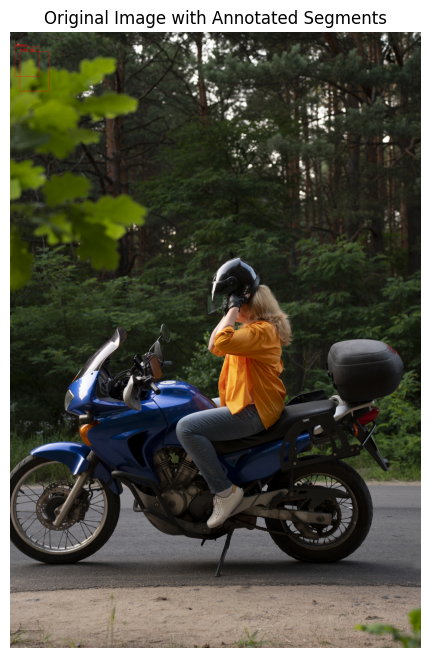

In [72]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Function to annotate and display the original image with bounding boxes
def display_annotated_image(image_path, object_data_list):
    # Load the original image
    image = cv2.imread(image_path)

    # Check if image loaded successfully
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib display

    # Annotate each object on the image
    for obj_data in object_data_list:
        # Extract bounding box and label info
        bbox = [int(val) for val in obj_data['bbox'].split(",")]
        label = obj_data['description']

        # Draw bounding box
        cv2.rectangle(image_rgb, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

        # Add label near the bounding box
        cv2.putText(image_rgb, label, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the annotated image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Original Image with Annotated Segments")
    plt.show()

# Sample object data (replace this with your actual object data)
object_data_example = [
    {
        "object_id": "object_1",
        "description": "Traffic Sign",
        "bbox": "100,200,400,600",
        "extracted_text": "STOP",
        "summary": "This is a traffic sign with the text STOP."
    },
    {
        "object_id": "object_2",
        "description": "Billboard",
        "bbox": "50,150,300,450",
        "extracted_text": "Safety First",
        "summary": "This is a billboard with a safety warning."
    }
]

# Path to the original input image
image_path = "data/input_images/woman-with-motorbike.jpg"
# Display the annotated image
display_annotated_image(image_path, object_data_example)

In [71]:
!shell
!ls data/input_images/

/bin/bash: line 1: shell: command not found
'woman-with-motorbike (1).jpg'	'woman-with-motorbike (2).jpg'	 woman-with-motorbike.jpg


In [73]:
import pandas as pd

# Function to generate a table summarizing the object data
def generate_summary_table(object_data_list):
    # Create a DataFrame from the object data
    df = pd.DataFrame(object_data_list)

    # Reorder columns for readability
    df = df[['object_id', 'description', 'bbox', 'extracted_text', 'summary']]

    # Display the table
    print("Summary Table for Segmented Objects:")
    display(df)

    # Save the table as CSV
    output_csv_path = "data/output/segmented_objects_summary.csv"
    df.to_csv(output_csv_path, index=False)
    print(f"Summary table saved to {output_csv_path}")

# Generate the summary table
generate_summary_table(object_data_example)

Summary Table for Segmented Objects:


object_id   description             bbox extracted_text  \
0  object_1  Traffic Sign  100,200,400,600           STOP   
1  object_2     Billboard   50,150,300,450   Safety First   

                                      summary  
0  This is a traffic sign with the text STOP.  
1  This is a billboard with a safety warning.

Summary table saved to data/output/segmented_objects_summary.csv


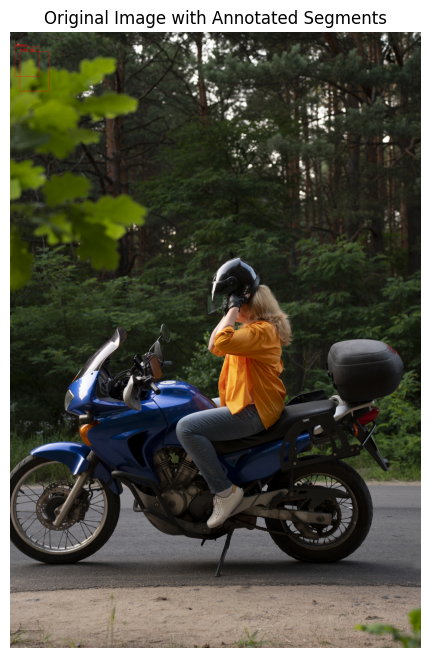

Summary Table for Segmented Objects:


object_id   description             bbox extracted_text  \
0  object_1  Traffic Sign  100,200,400,600           STOP   
1  object_2     Billboard   50,150,300,450   Safety First   

                                      summary  
0  This is a traffic sign with the text STOP.  
1  This is a billboard with a safety warning.

Summary table saved to data/output/segmented_objects_summary.csv


In [74]:
# Full solution that displays both the annotated image and table
def generate_output(image_path, object_data_list):
    # Step 1: Display annotated image
    display_annotated_image(image_path, object_data_list)

    # Step 2: Generate and display table summary
    generate_summary_table(object_data_list)

# Call the combined output generation function
generate_output(image_path, object_data_example)